In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import pickle, os, glob
from EEG.info import info_exp
from EEG.converter import converter_mne
import mne
import numpy as np
import sys

In [2]:
root = "C:\\eeg\\01exp\\"
name = "20161129_DBS_001"

def load(path,name):
    with open(path + '/' + name, 'rb') as input:
        data = pickle.load(input)
        return data

In [3]:
test = load(root + name,'exp_data_aligned.cls')

In [4]:
test.getinfo()

Experiment status:  True ; Num tests:  12
Align status:  True
Respondent name:  Ольга Ветрова
Description: Эксперимент с обратной связью
Labels_names: [ удалено, отдых, левая, правая ]
Frequency: 1000
Count train activities:  45
Count tests activities: [ 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30 ]
Time of activity: 4500
Type_chanels: eeg  Montage: standard_1005
------------------------------------------------------------------
Chanels_names:
------------------------------------------------------------------
FC5        FT7        FC3        FCz        FC4        FT8       
T3         C3         Cz         T4         C4        
TP7        CP3        CPz        CP4        TP8       
FC1        FC2        FC6        P4         C5        
C1         C2         C6         P3         CP5       
CP1        CP2        CP6        POz       
------------------------------------------------------------------
List tests
------------------------------------------------------------------
2016112

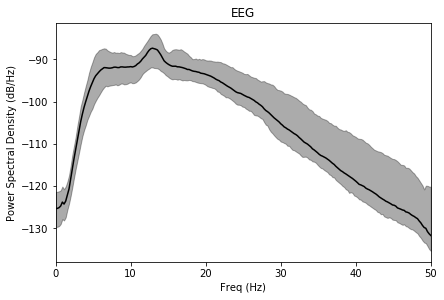

Figure(432x288)


In [5]:
data  = converter_mne(test)
epochs = data.train_epochs()
#raw.filter(6,16,phase='zero',filter_length='auto', fir_window='hamming',l_trans_bandwidth='auto', h_trans_bandwidth='auto')
print epochs.plot_psd(area_mode='range', tmax=4.499,fmax=50.)

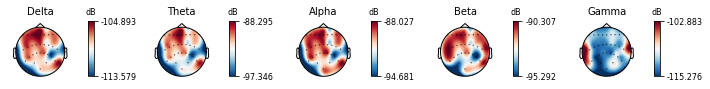

Figure(720x108)


In [6]:
print epochs.plot_psd_topomap()
picks = mne.pick_types(info=data.mne_info(), meg=False, eeg=True, misc=False)

In [25]:
mne.set_log_level(verbose = "ERROR")
# get test list
test_list = []
for i in range(0,data.num_tests):
    epochs_test = data.test_epochs(i)
    Y_test = epochs_test.events[:,-1]
    X_test = epochs_test.get_data()
    test_list.append({'Y_test':Y_test,'X_test':X_test})

In [26]:
import scipy.signal as spsig
def data_prep(data, sfreq, fmin, fmax):
    [b_high, a_high] = spsig.butter(4, float(fmin) / (sfreq / 2), 'high')
    [b_low, a_low] = spsig.butter(4, float(fmax) / (sfreq / 2), 'low')

    chunk_high = spsig.lfilter(b_high, a_high, data)
    chunk_low = spsig.lfilter(b_low, a_low, chunk_high)
    return chunk_low

## SCP decoder

In [39]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from mne.decoding import CSP
from sklearn.multiclass import OneVsRestClassifier

Y_train = epochs.events[:,-1]
X_train = epochs.get_data()
X_train = data_prep(X_train, 1000, 6, 16)

# train classifier
svc = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)


X_train = csp.fit_transform(X_train, Y_train)
svc.fit(X_train, Y_train)

LDA_scores = []
for i in range(0, len(test_list)):
    X_test = data_prep(test_list[i]['X_test'], 1000, 6, 16)
    X_test = csp.transform(X_test)
    LDA_scores.append(svc.score(X_test, test_list[i]['Y_test']))

print "MAX:", np.max(LDA_scores)
print "MEAN:", np.mean(LDA_scores)
print "MIN:", np.min(LDA_scores)
print "DISP:", np.std(LDA_scores)

MAX: 0.966666666667
MEAN: 0.772222222222
MIN: 0.466666666667
DISP: 0.140655432235


## ICA remove artefacts

In [40]:
from mne.preprocessing import ICA, create_ecg_epochs, create_eog_epochs

ica = ICA(n_components=0.95, method='fastica')
ica.fit(epochs)

# maximum number of components to reject
n_max_ecg, n_max_eog = 3, 1  # here we don't expect horizontal EOG components

ecg_epochs = create_ecg_epochs(raw, tmin=-.5, tmax=.5)

ValueError: Unable to generate artificial ECG channel

In [38]:


Y_train = epochs.events[:,-1]
X_train = epochs.get_data()
#X_train = data_prep(X_train, 1000, 6, 16)

# train classifier

average_eog = create_eog_epochs(epochs).average()
print('We found %i EOG events' % average_eog.nave)
average_eog.plot_joint()

ica = ICA()
ica.fit(epochs)
ica.apply(epochs)

X_mod = epochs.get_data()

print X_train[0]
print X_mod[0]

X_train = csp.fit_transform(X_train, Y_train)
print X_train.shape
break
svc.fit(X_train, Y_train)

LDA_scores = []
for i in range(0, len(test_list)):
    X_test = data_prep(test_list[i]['X_test'], 1000, 6, 16)
    X_test = csp.transform(X_test)
    LDA_scores.append(svc.score(X_test, test_list[i]['Y_test']))

print "MAX:", np.max(LDA_scores)
print "MEAN:", np.mean(LDA_scores)
print "MIN:", np.min(LDA_scores)
print "DISP:", np.std(LDA_scores)

RuntimeError: EEG 61 or EEG 62 channel not found !!